In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"

# Solving Helmholtz problems

> The models used by the Helmholtz solvers are derived with [Santeri Kaupinmäki](https://bug.medphys.ucl.ac.uk/santeri-kaupinmaki)

Depending on the heterogeneity of the model, the Helmholtz solver automatically calls different functions to calculate the computationally cheapest Helmholtz operator. The solution is always found using an iterative linear solver with matrix-free linear operators.

In [3]:
from jax import numpy as jnp
from jax import jit

# Defining geometry
from jwave.geometry import kGrid, Medium, _circ_mask

N = (128, 192)
dx = (1., 1.)
omega = 1.

# Making geometry
grid = kGrid.make_grid(N, dx)

# Source field
src_field = jnp.zeros(N).astype(jnp.complex64)
src_field = src_field.at[32:96, 22].set(1.0)

# Speed of sound
sound_speed = jnp.zeros(N)
sound_speed = sound_speed.at[20:105,20:200].set(1.)
sound_speed = sound_speed*(1-_circ_mask(N, 70,[64,145]))*(1-_circ_mask(N,50,[64,18])) +1

## The Homogeneous density case
For a medium with homogeneous density and no attenuation, the wave equations is given as 

$$
\left( \nabla^2 - \frac{1}{c_0^2}\frac{\partial^2}{\partial t^2}\right)p = -\frac{\partial}{\partial t}S_M
$$

Taking the Fourier transform in time, and denoting the Fourier transform of a function $f$ as $\hat f$, one gets the Helmholtz equation

$$
\left( \nabla^2 + \frac{\omega^2}{c_0^2}\right)\hat p = -i\omega \hat S_M.
$$

Note that there both $\hat p$ and $\hat S_M$ are complex.

#### Perfectly matched layer
To enforce the Sommerfield radiation condition, the components of the gradient operator $\hat \nabla$ [are modified as](http://oomph-lib.maths.man.ac.uk/doc/pml_helmholtz/scattering/latex/refman.pdf)

$$
\frac{\partial}{\partial x_j} \to \frac{1}{\gamma_j} \frac{\partial}{\partial x_j},
\qquad
\gamma_j = 1 + \frac{1}{k_0}\sigma_j(x), \qquad \sigma_j(x)\frac{1}{\|x_j - x_j^{PML}\|}
$$

and the equations solved is 

$$
\left( \hat\nabla^2 + \frac{\omega^2}{c_0^2}\right)\hat p = -i\omega \hat S_M.
$$

In [4]:
# Medium properties
medium = Medium(
    sound_speed=sound_speed,
    density=None,
    attenuation=None,
    pml_size=15
)

In [10]:
from jwave.physics import solve_helmholtz

def get_field(lens_sos):
    lens_sos=lens_sos[0]
    sound_speed = jnp.zeros(N)
    sound_speed = sound_speed.at[20:105,40:130].set(lens_sos)
    sound_speed = sound_speed*(1-_circ_mask(N, 40,[80,100])) +1

    medium = Medium(
        sound_speed=sound_speed,
        density=None,
        attenuation=None,
        pml_size=15
    )
    field = solve_helmholtz(grid, medium, src_field, omega, method="gmres", maxiter=2000)
    return jnp.reshape(field, (-1,))

def field_to_image(field_vec):
    return jnp.reshape(field_vec, sound_speed.shape)

field = field_to_image(get_field(lens_sos=[1.]))

Text(0.5, 1.0, 'Wavefield magnitude')

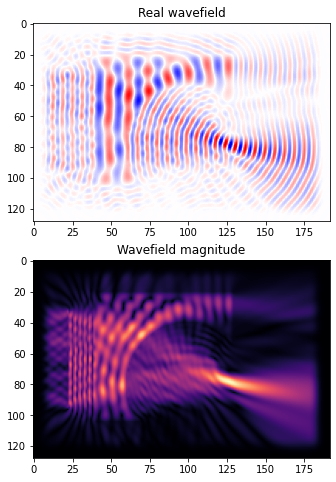

In [11]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2,1,figsize=(15,8))

axes[0].imshow(field.real, vmin=-2., vmax=2., cmap="seismic")
axes[0].set_title("Real wavefield")
axes[1].imshow(jnp.abs(field), vmin=0, cmap="magma")
axes[1].set_title("Wavefield magnitude")

Adding linear uncertanty propagation

In [12]:
from luprox import linear_uncertainty

In [13]:
get_field_lup = linear_uncertainty(get_field)

x = jnp.array([1.])
# 2.5% std on the speed of sound average value
covariance = jnp.array([[(0.05)**2]]) # Covariance matrix for x (scalar for 1D random variables)

In [14]:
mu_linear, cov_linear = get_field_lup(x, covariance)

In [17]:
cov_linear = jnp.diag(cov_linear)

In [18]:
cov_image_linear = field_to_image(cov_linear)
mu_image_linear = field_to_image(mu_linear)

Text(0.5, 1.0, 'Wavefield magnitude')

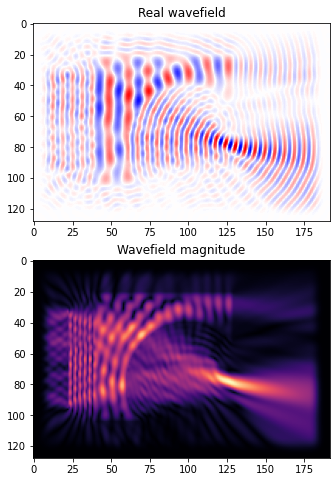

In [19]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2,1,figsize=(15,8))

axes[0].imshow(mu_image_linear.real, vmin=-2, vmax=2, cmap="seismic")
axes[0].set_title("Real wavefield")
axes[1].imshow(jnp.abs(mu_image_linear), vmin=0, cmap="magma")
axes[1].set_title("Wavefield magnitude")

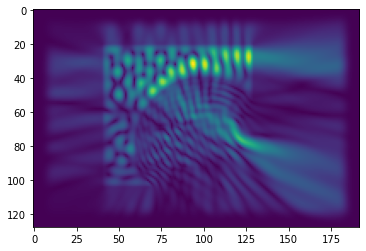

In [20]:
plt.imshow(jnp.sqrt(jnp.abs(cov_image_linear)))

In [21]:
from luprox import mc_uncertainty
from jax import random

In [22]:
get_field_up = mc_uncertainty(get_field, trials=100)

In [23]:
mu_mc, cov_mc = get_field_up(x, covariance, key=random.PRNGKey(30))

(100, 24576)


In [24]:
cov_image_mc = field_to_image(cov_mc)
mu_image_mc = field_to_image(mu_mc)

Text(0.5, 1.0, 'Wavefield std (MC)')

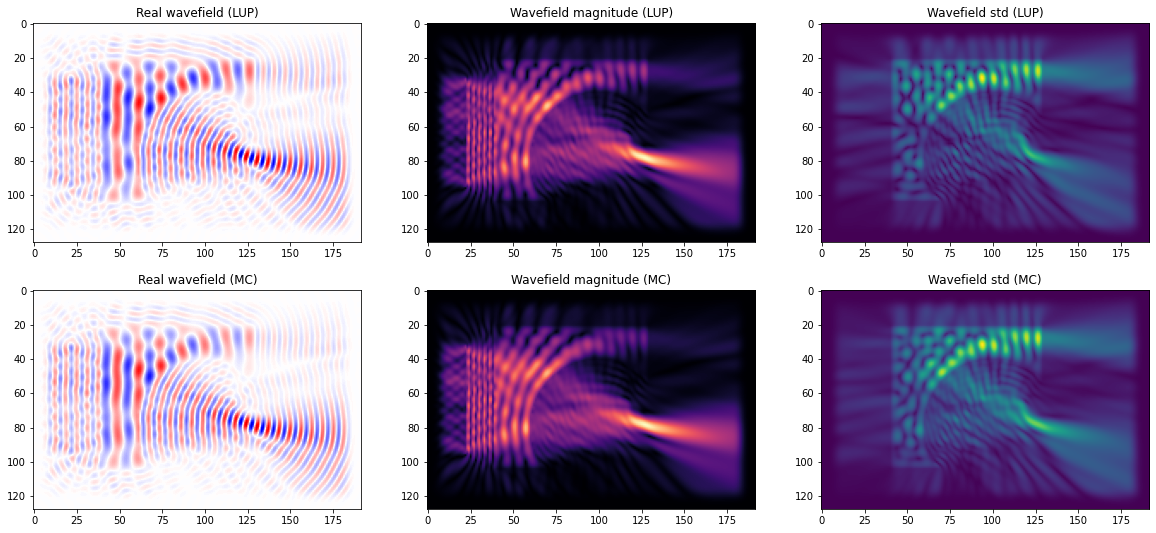

In [25]:
fig, ax = plt.subplots(2,3,figsize=(20,9))

ax[0,0].imshow(mu_image_linear.real, vmin=-2, vmax=2, cmap="seismic")
ax[0,0].set_title("Real wavefield (LUP)")
ax[0,1].imshow(jnp.abs(mu_image_linear), vmin=0, cmap="magma")
ax[0,1].set_title("Wavefield magnitude (LUP)")
ax[0,2].imshow(jnp.sqrt(jnp.abs(cov_image_linear)), vmin=0)
ax[0,2].set_title("Wavefield std (LUP)")

ax[1,0].imshow(mu_image_mc.real, vmin=-2, vmax=2, cmap="seismic")
ax[1,0].set_title("Real wavefield (MC)")
ax[1,1].imshow(jnp.abs(mu_image_mc), vmin=0, cmap="magma")
ax[1,1].set_title("Wavefield magnitude (MC)")
ax[1,2].imshow(jnp.sqrt(jnp.abs(cov_image_mc)), vmin=0)
ax[1,2].set_title("Wavefield std (MC)")

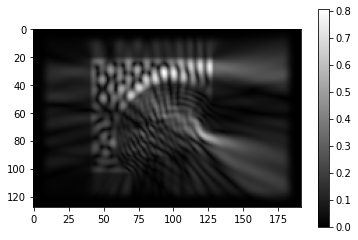

In [26]:
plt.imshow(jnp.sqrt(jnp.abs(cov_image_linear)), vmin=0, cmap="gray")
plt.colorbar()

Text(0.5, 1.0, 'Wavefield std (MC)')

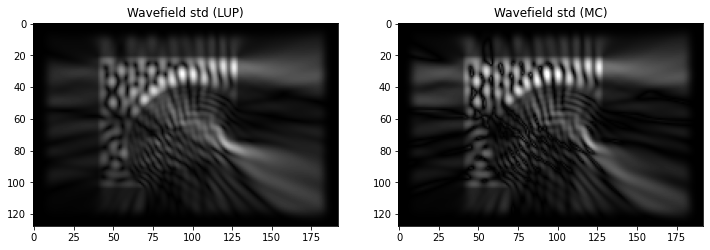

In [27]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].imshow(jnp.sqrt(jnp.abs(cov_image_linear)), vmin=0, cmap="gray")
ax[0].set_title("Wavefield std (LUP)")

ax[1].imshow(
    jnp.abs(jnp.sqrt(jnp.abs(cov_image_mc)) - jnp.sqrt(jnp.abs(cov_image_linear))), 
    vmin=0.,  
    vmax=.3, 
    cmap="gray"
)
ax[1].set_title("Wavefield std (MC)")

# Runtimes

According to [Eerlanga](https://epubs.siam.org/doi/pdf/10.1137/040615195), Bi-CGSTAB is to be preferred to GMRES not only for memory requirements (the number of vectors in memory is fixed to 7, rather than variable as in restarted GMRES), but also because of faster convergence.

Let's check if that's true for Fourier spectral discretization too:

In [28]:
print("Runtime with LUP")
%timeit get_field_lup(x, covariance)[1].block_until_ready()

Runtime with LUP
11.7 s ± 1.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
print("Runtime with MC")
%timeit  get_field_up(x, covariance, key=random.PRNGKey(30))[1].block_until_ready()

Runtime with MC
1min 15s ± 233 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
!nvidia-smi

Thu Apr 22 12:42:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P40           On   | 00000000:04:00.0 Off |                  Off |
| N/A   32C    P0    52W / 250W |  21197MiB / 24451MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P40           On   | 00000000:05:00.0 Off |                  Off |
| N/A   

## References

